# Approximating ATMF Option Prices

## Simplifying Black-Scholes for intuitive approximations

When it comes to pricing and hedging options, having a fast, reliable and accurate pricer is paramount. However it's not always essential to have such razor sharp accuracy - when it comes to sense-checking or even assessing trade ideas it can be useful to have a few useful rough-and-ready approximations to speed things up. This is one of those such approximations for computing the price and vega of at-the-money-forward (ATMF) options.

## What does at-the-money-forward (ATMF) mean?

At-the-money (ATM) is a common term to refer to an option with a strike at the same level as the current spot price. However, when it comes to valuing vanilla options this isn't what matters - what matters is the 'forward'. To understand why, let's quickly run through a few concepts.

## Risk neutral measure

When it comes to making things sound and look much more complicated than they are, financial maths is __king__. For me, the term 'risk neutral measure' has got to be up there as one of the most obscure ways to label something so relatively simple. The idea is the following: to value options we need to have some idea of a probability distribution of the stock at the expiry of our option. If we have a probability distribution that says that it will never end up in-the-money (ITM) then we would never pay anything for the option because it will always have a terminal value of 0. Vice versa, if we have a probability distribution that dictates that the stock price at expiry will _always_ be ITM (with varying degrees of ITM-ness) then we would pay much more for that. The central question then becomes: where do we get that distribution from?

We _could_ make it up. Medium has no shortage of articles telling you how you could make __millions__ predicting stock price moves using the latest and greatest machine learning algorithm, but as the plethora of PhDs in finance will attest to - consistently predicting stock price moves (and implicitly their distributions at a given time in the future) is no mean feat. Instead, we use observable market information out there to _imply_ what the distribution of the stock is. 

Black scholes formula:

$$ C(S, t) = S N(d_1) - N(d_2) K e^{-rT} $$

where we have:

$$ d_1 = \frac{1}{\sigma \sqrt{T-t}} [ln(\frac{S}{K}) + (r + \frac{\sigma^2}{2}) (T - t)] $$

and correspondingly:

$$ d_2 = d_1 - \sigma \sqrt{T-t} $$

If we assume that `S = K` and `r = 0` then we can simplify this to:

$$ C(S, t) = S [N(d_1) - N(d_2)] $$

where we have:

$$
\begin{align}
d_1 &= \frac{1}{\sigma \sqrt{T-t}} [\frac{\sigma^2}{2} (T - t)] \\
    &= \frac{\sigma}{2} \sqrt{\tau}
\end{align}
$$

where we have made the substituion:

$$ \tau = T - t $$

As a result this then gives us for `d_2`:

$$
\begin{align}
d_2 &= d_1 - \sigma \sqrt{T-t} \\
    &= \frac{\sigma}{2} \sqrt{\tau} - \sigma \sqrt{\tau} \\
    &= - \frac{\sigma}{2} \sqrt{\tau} \\
    &= - d_1
\end{align}
$$

We can now plug this back into the equation for the price of a call to obtain:

$$ C(S, t) = S [N(d_1) - N(-d_1)] $$

In [2]:
# usual suspects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import warnings

# some config
%config Completer.use_jedi = False
warnings.filterwarnings('ignore')
sns.set() 

Now let's plug some numbers in to represent what we are trying to work out. Let's go with a `T=1` year option with a implied volatility of `40vol`. We can plot the two quantities we need to subtract:

In [64]:
vol = 0.4

xs = np.linspace(-3, 3, 100*6+1)
ys = [stats.norm.cdf(x) for x in xs]
ys_pdf = [stats.norm.pdf(x) for x in xs]

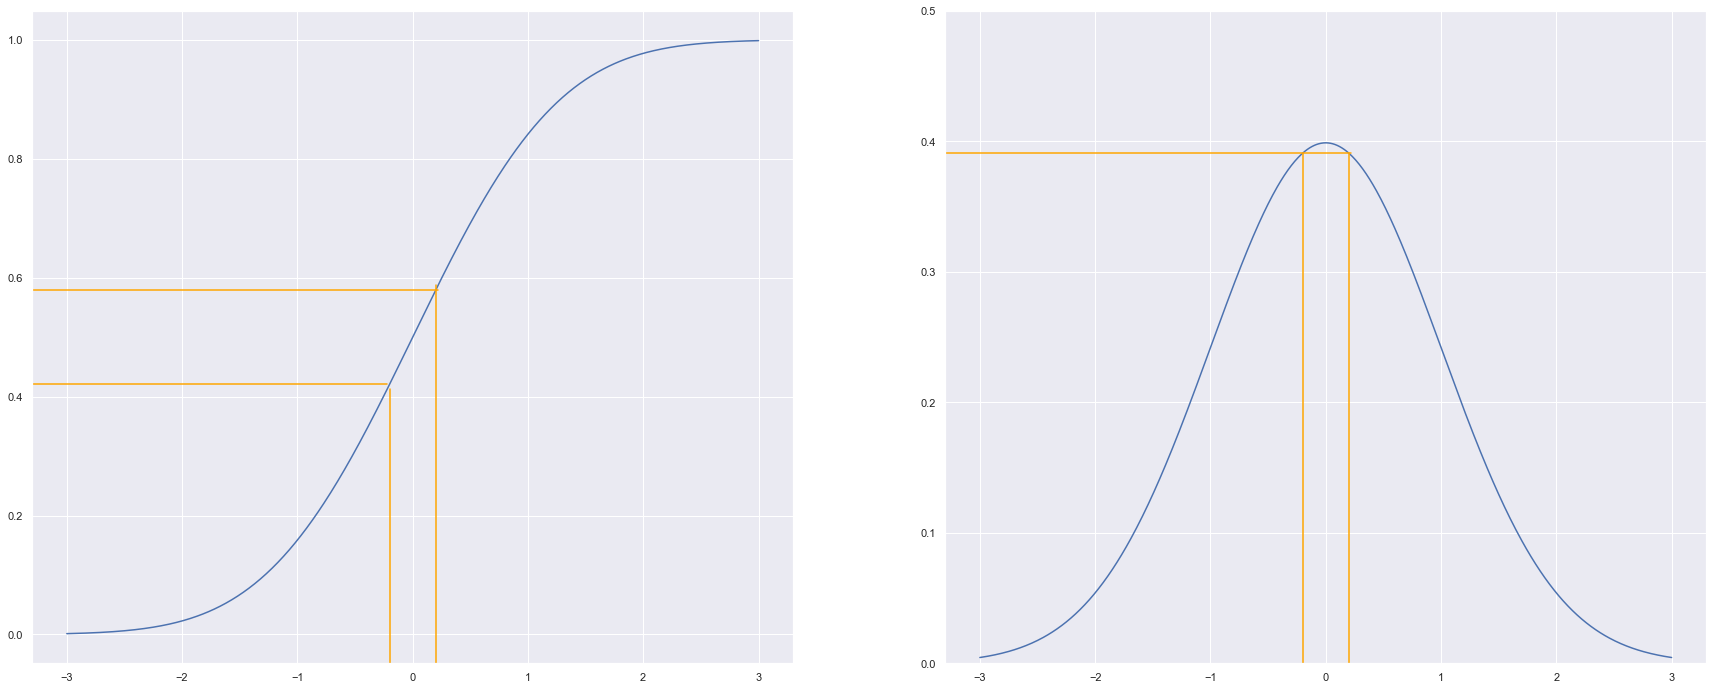

In [66]:
d_1 = vol/2 * 1**0.5

fig, axes = plt.subplots(ncols=2, figsize=(30,12))
axes = axes.reshape(-1)


axes[0].plot(xs, ys)
axes[0].axvline(-d_1, ymax=stats.norm.cdf(-d_1), color='orange')
axes[0].axhline(y=stats.norm.cdf(-d_1), xmax=0.5 - d_1/6, color='orange')

axes[0].axvline(d_1, ymax=stats.norm.cdf(d_1), color='orange')
axes[0].axhline(y=stats.norm.cdf(d_1), xmax=0.5 + d_1/6, color='orange')


axes[1].plot(xs, ys_pdf)
axes[1].set_ylim(0, 0.5)

axes[1].axvline(x=-d_1, ymin=0, ymax=stats.norm.pdf(d_1) / 0.5, color='orange')
axes[1].axvline(d_1, ymin=0, ymax=stats.norm.pdf(d_1) / 0.5, color='orange')
axes[1].axhline(stats.norm.pdf(d_1), xmin=0, xmax=0.5 + d_1/6, color='orange');

So as we can more clearly see from the right hand graph we need to work out the area of that rectangle. Unfortunately we don't know of the top of our heads where the vertical orange lines intersedct the blue pdf. However, we do know:
 - it's symmetric
 - it's close to the max value for the pdf

We can use these facts to generate an approximation:

$$
\begin{align}
C(S, t) &= S [N(d_1) - N(-d_1)] \\
        &= S [\frac{1}{\sqrt{2 \pi}} * [d_1 - d_2]] \\
        &= S [\frac{1}{\sqrt{2 \pi}} * [\frac{\sigma}{2} \sqrt{\tau} - - \frac{\sigma}{2} \sqrt{\tau}] \\
        &= S \frac{\sigma \sqrt{\tau}}{\sqrt{2 \pi}}
\end{align}
$$

Where this approximately gives us:

$$ C(S, t) = 0.4 S \sigma \sqrt{\tau} $$

If we compute the vega as the derivative with respect to volatility then we can express the vega as approximately:

$$
\begin{align}
vega &= \frac{dC}{d\sigma} \\
     &= 0.4 S \sqrt{\tau}
\end{align}
$$

which as a percentage gives us:

$$ vega = 0.4 \sqrt{\tau} $$

or for a 1 year ATMF option a vega of 0.4% - 40bps.

## How does the approximation fare?

We can take the above approximation and use it to see how it compares when we:
 - vary the implied volatility
 - vary the tenor

In [67]:
from opcoes.black_scholes import compute_prices

In [79]:
def px_approx(spot, vol, tau):
    return 0.4 * spot * vol * tau**0.5

In [69]:
compute_prices(100, 100, 0, 0, vol, 4, 3)[0][:-1]

array([27.09655105, 25.98558642, 24.8170366 , 23.58228444, 22.27025892,
       20.86632199, 19.35040595, 17.69367262, 15.85194189, 13.75097699,
       11.2462916 ,  7.96556746])

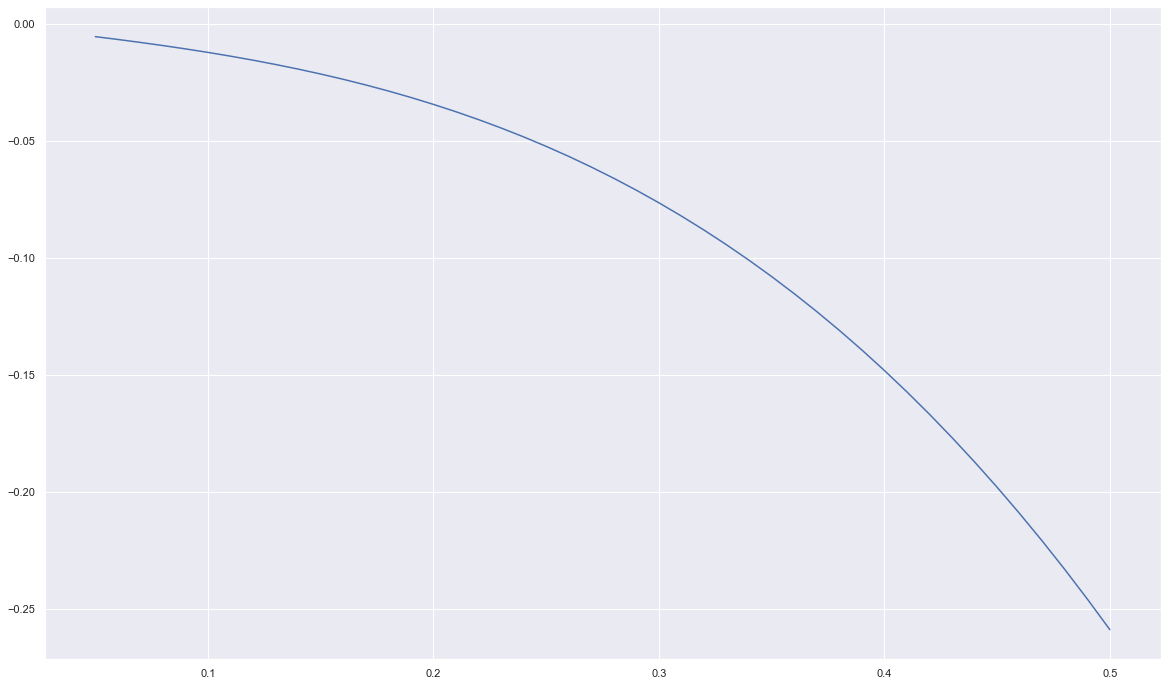

In [87]:
fig, ax = plt.subplots(figsize=(20,12))

ax.plot(np.linspace(0.05, 0.5, int((0.5-0.05)*100 + 1)), [(compute_prices(100, 100, 0, 0, x, 1, 1)[0][0] - px_approx(100, x, 1)) for x in np.linspace(0.05, 0.5, int((0.5-0.05)*100 + 1))]);